<a href="https://colab.research.google.com/github/kristina-arezina/Text-Classification-using-Neural-Network/blob/main/Text_Classification_using_Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report

import matplotlib.pyplot as plt

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import np_utils
from keras.models import Sequential
from keras import layers
from keras.wrappers.scikit_learn import KerasClassifier

# Data

Download twitter data from Kaggle: https://www.kaggle.com/kazanova/sentiment140 

**Context**

This is the sentiment140 dataset. It contains 1,600,000 tweets extracted using the twitter api . The tweets have been annotated (0 = negative, 4 = positive) and they can be used to detect sentiment.

**Content**

It contains the following 6 fields: 

*   target: the polarity of the tweet (0 = negative, 4 = positive)
*   ids: The id of the tweet ( 2087)
*   date: the date of the tweet (Sat May 16 23:58:44 UTC 2009)
*   flag: The query (lyx). If there is no query, then this value is NO_QUERY.
*   user: the user that tweeted (robotickilldozr)
* text: the text of the tweet (Lyx is cool)

In [ ]:
df = pd.read_csv('/content/drive/My Drive/Colab-Notebooks/Dec-2020-Newsletter/tweet-data.csv',
                 encoding='ISO-8859-1', 
                 names=[
                        'target',
                        'id',
                        'date',
                        'flag',
                        'user',
                        'text'
                        ])

In [ ]:
df.head()

,target,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


Two classes in the dataset

In [ ]:
df.target.unique()

array([0, 4])

Check how equally distributed those classes are.

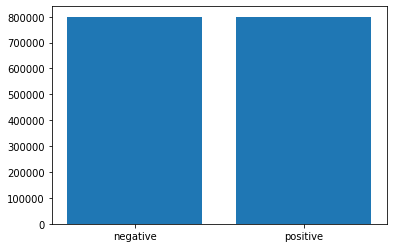

In [ ]:
classes = df.target.unique()
counts = []

for i in classes:
  count = len(df[df.target==i])
  counts.append(count)

plt.bar(['negative', 'positive'], counts)
plt.show()

Even class distribution helps us a lot in text classifiction. Imagine a situation where 95% of data is in one class and the rest 5% is split among other 5 classes. If we wouldn't do anything about it model would just learn to guess the 95% class all the time and would be correct 95% of the time on the data we would use.

To start modelling we still need to do a couple of things:


1.   Split data into train and test datasets
2.   Tokenize it
3.   Pad the text
4. Encode the labels

# Train/test split
We don't really need all 1.6 Million tweets for training so we can take a sample of 10% and then split taht into 80% for training and 20% for testing.

In [ ]:
sample_size = int(len(df)*0.1)
sampleDf = df.sample(sample_size, random_state=23)
x = sampleDf.text.values
y = sampleDf.target.values
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=32)

# Tokenization
What we need to do now is to tokenize text (essentialy turning words into tokens). The difference from vectorization that we used in Linear Regression notebook is that we do not count each token occurence in the text. Instead we just turn words into tokens and that's about it. Comparing this to Logistic Regression (LR) example you'll see that in this method we keep the order of the words intact, while, in the LR example we loose that information.

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train)

X_train = tokenizer.texts_to_sequences(x_train)
X_test = tokenizer.texts_to_sequences(x_test)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

Our tokenized dataset will essentially consist of index of each word that is used in training dataset. We can check how it looks by simply printing the first tweet both as it was and after tokenization.

In [ ]:
print(x_train[0])
print(X_train[0])

@teefy1983 aww my poor mexican!!! He no feel good at all 
[33672, 361, 5, 351, 3268, 113, 37, 110, 28, 23, 31]


# Padding
Before modelling we want to make sure our inputs are the same size, since we are using neural network with a fixed input size. \\
First we figure out the max len.

In [ ]:
lens_train = [len(i) for i in X_train]
lens_test = [len(i) for i in X_test]
lens = lens_train + lens_test

maxlen = np.max(lens)

print('Max len:', maxlen)

Max len: 118


Then we pad our inputs to fit that size.

In [ ]:
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

# Label Encoding
We could get away with other approach but you might want to use this for more than binary classification.

In [ ]:
encoder = LabelEncoder()
encoder.fit(y)
encoded_Y_test = encoder.transform(y_test)
encoded_Y_train = encoder.transform(y_train)

# convert integers to dummy variables (i.e. one hot encoded)
dummy_y_test = np_utils.to_categorical(encoded_Y_test)
dummy_y_train = np_utils.to_categorical(encoded_Y_train)

# Modelling
The model that we use here is a simple Neural Network. I'll add some comments to explain what each line does.

In [ ]:
embedding_dim = 100  # vector representation of words/neuron amount after the input https://datascience.stackexchange.com/questions/53995/what-does-embedding-mean-in-machine-learning#:~:text=In%20the%20context%20of%20machine,with%20other%20models%20as%20well.

model = Sequential()  # initiates the model
model.add(layers.Embedding(input_dim=vocab_size,  # adds the first [input] layer which will be our tokenized tweets
                          output_dim=embedding_dim,  # the embedding of that tweet, essentially inputs output
                          input_length=maxlen))  # size of the input layer determined by maxlen calculated before
model.add(layers.Dropout(0.2))  # dorpouts are added to help with overtraining, essentially "turns off" said amount of neurons before giving information to the next layer
model.add(layers.GlobalMaxPool1D())  # https://computersciencewiki.org/index.php/Max-pooling_/_Pooling
model.add(layers.Dropout(0.2))
model.add(layers.Dense(50, activation='relu'))  # additional hidden layer
model.add(layers.Dropout(0.2))
model.add(layers.Dense(50, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(2, activation='softmax'))  # prediction layer, 2 is the number of classes we have
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 118, 100)          11789900  
_________________________________________________________________
dropout (Dropout)            (None, 118, 100)          0         
_________________________________________________________________
global_max_pooling1d (Global (None, 100)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 50)                5050      
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                2

So we have our model. All we need now is to train it.

In [ ]:
history = model.fit(X_train, dummy_y_train,
                    epochs=3,  # times model will run through the data
                    verbose=True,
                    validation_data=(X_test, dummy_y_test),
                    batch_size=128)  # data is set to batches we are sent to the model to predict, imagine each batc as a step in which model tries to predict the class and then checks the right answer and corrects it's weights with backpropogation
loss, accuracy = model.evaluate(X_train, dummy_y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, dummy_y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Epoch 1/3
1000/1000 [==============================] - 83s 83ms/step - loss: 0.5780 - accuracy: 0.6761 - val_loss: 0.4514 - val_accuracy: 0.7921
Epoch 2/3
1000/1000 [==============================] - 82s 82ms/step - loss: 0.4016 - accuracy: 0.8175 - val_loss: 0.4436 - val_accuracy: 0.7936
Epoch 3/3
1000/1000 [==============================] - 83s 83ms/step - loss: 0.3246 - accuracy: 0.8575 - val_loss: 0.4692 - val_accuracy: 0.7846
Training Accuracy: 0.9092
Testing Accuracy:  0.7846


Let's have a nice plot of our training process.

In [ ]:
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

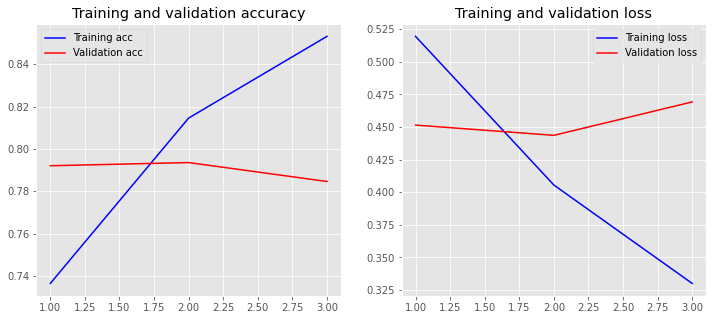

In [ ]:
plot_history(history)

So there's a couple of interesting things we can see here. Ussually you would see train and validation accuracy both increase over time. Essentially the point where training crosses validation you would want to stop training as it means that model is starting to remember exact things instead of learning patterns, which here is at 2nd epoch. Another thing to take into account is that validation accuracy decreases quite singnificantly over time, instead of growing. Why? Well we have quite a lot of data, so it might very well be that it's enough to have 2 epochs to fully train it before changing learning rate. Essentially, what this shows is that model is rapidly overtraining. If we would remove the dropout layers in the model see ```model.add(layers.Dropout(0.2))``` under [Modeling](#Modelling).

**Essentially model is prone to overtrain**

# Confussion matrix
Before jumping into other models it's always good to check how our model performs in different classes. For that we can use confussion matrix.

It essentially shows how many times model predicted which class and how many of those times the class it slected was the right one. Here columns are true values and lines are predicted values.

So here we need to do it a bit differently from the way we did it in the Logistic Regression notebook. We have encoded our classses using encoder. Here are those classes.

In [ ]:
encoder.classes_

array([0, 4])

And our predictions are stored as arrays with probabilities fir each class.

In [ ]:
y_pred = model.predict(X_test)
y_pred

array([[9.9938953e-01, 6.1048294e-04],
       [2.4718824e-03, 9.9752814e-01],
       [6.0995501e-01, 3.9004493e-01],
       ...,
       [7.6248258e-01, 2.3751740e-01],
       [2.1706244e-01, 7.8293753e-01],
       [3.0216521e-01, 6.9783473e-01]], dtype=float32)

Here you can see that we have array of arrays of 2 probabilities for each class. So we need to turn those into classes.

In [ ]:
y_predDecoded = [encoder.classes_[np.argmax(i)] for i in y_pred]  # here we get the max probability from those arrays and then based on that select which class is it.
cm = confusion_matrix(y_test, y_predDecoded, labels=df.target.unique())  # same confusion matrix code as in Logistic Regression
df_cm = pd.DataFrame(cm, index=df.target.unique(), columns=df.target.unique())
df_cm

,0,4
0,12272,3740
4,3152,12836


For a better understanding you could use percentage expression.

In [ ]:
df_cm_percentage = df_cm.copy()
for i in df_cm_percentage:
  df_cm_percentage[i]/=df_cm_percentage[i].sum()

df_cm_percentage

,0,4
0,0.795643,0.225627
4,0.204357,0.774373


Good, so in the end model learnt to classify both classes about the same. Even though we are using a simple and really overtrained by epoch 10 Neural Network as another base measure to check if the problem is solvable and what results we might expect some insights can be derived here (some the same as LR):

Classes are evenly distributed, thus we won't overtrain on one class compared to the other and here we overtrain equally on both :D
Neural Network before overtraining and with no learning rate adjustments achieved 80% accuracy, meaning we should be able to get a slightly better result adjusting learning rate and a much better result using language models such as BERT
Both classes are predicted equally well

# Test

Now we need to check if it actually works. Let's just copy a comment in one of Naval's tweets.

The comment is: You can’t move a trust-network any more than you can transplant a forest.

In [ ]:
tweet = 'You can’t move a trust-network any more than you can transplant a forest.'
vectTweet = tokenizer.texts_to_sequences(np.array([tweet]))  # vectorizes the tweet using our vectorizer
vectTweet = pad_sequences(vectTweet, padding='post', maxlen=maxlen)  # adds padding

prediction = model.predict(vectTweet)  # predicts class of the tweet
print('Tweet is', 'positive' if encoder.classes_[np.argmax(prediction)]==4 else 'negative')

Tweet is positive


Let's just make sure our model works okay with very specific sentiments.

In [ ]:
tweetList = ['Best tweet ever!', 'Mondays are the worst...']
vectTweet = tokenizer.texts_to_sequences(np.array(tweetList))  # vectorizes the tweet using our vectorizer
vectTweet = pad_sequences(vectTweet, padding='post', maxlen=maxlen)  # adds padding

prediction = model.predict(vectTweet)  # predicts class of the tweet
for enum, i in enumerate(tweetList):
  print(i, '| This tweet is', 'positive' if encoder.classes_[np.argmax(prediction[enum])]==4 else 'negative')

Best tweet ever! | This tweet is positive
Mondays are the worst... | This tweet is negative
